In [180]:
import matplotlib.pyplot as plt
import math
import random
import numpy as np
import time
import pandas as pd

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.width=500

In [181]:
def find_east_most(left_hull):
    point_max = [float('-inf'), float('-inf')]
    east_point_index=-1
    for index in range(0, len(left_hull)):
        point=left_hull[index]
        if (point[0] > point_max[0] or (point_max[0]==point[0] and point[1] < point_max[1])):
            point_max=point
            east_point_index=index
    return east_point_index

def find_west_most(right_hull):
    point_min = [float('inf'), float('inf')]
    west_point_index=-1
    for index in range(0,len(right_hull)):
        point = right_hull[index]
        if (point[0] < point_min[0] or (point_min[0]==point[0] and point[1] > point_min[1])):
            point_min=point
            west_point_index=index
    return west_point_index

# compares direction of three points
def get_direction(a,b,c):
    slope_compare = ((b[0]- a[0]) * (c[1] - a[1])) - ((b[1] - a[1]) * (c[0] - a[0]))
    if (slope_compare==0):
        return 'COLLINEAR'
    elif (slope_compare > 0):
        return 'CLOCKWISE'
    else:
        return 'COUNTERCLOCKWISE'

In [182]:
#utility functino to calculate the mean of a set of numbers
def calc_mean(coordinates):
    mean_sum=0
    for coordinate in coordinates:
        mean_sum+=coordinate
    return mean_sum/len(coordinates)

# sorts coordinates in clockwise order around the hull center
def sort_coordinates_clockwise(points):
    x_coords = [point[0] for point in points]
    y_coords=[point[1] for point in points]
    centerX = calc_mean(x_coords)
    centerY = calc_mean(y_coords)
    x_coords_center_relative =[point-centerX for point in x_coords]
    y_coords_center_relative = [point-centerY for point in y_coords]
    angles = np.arctan2(y_coords_center_relative, x_coords_center_relative)
    indices = np.argsort(-angles)
    sorted_final=[]
    for index in indices:
        sorted_final.append(points[index])
    return sorted_final
 
# merge step
def merge_hulls(left_subhull, right_subhull):
    left_hull = sort_coordinates_clockwise(left_subhull)
    right_hull= sort_coordinates_clockwise(right_subhull)
    
    #find bridge points
    west_most = find_west_most(right_hull)
    east_most = find_east_most(left_hull)
    right_index = west_most
    left_index = east_most
  
    #upper tangent find
    l_len=len(left_hull)
    r_len =len(right_hull)
    tangent_points_found=False
   
    while not tangent_points_found:
        tangent_points_found=True
        while get_direction(right_hull[right_index],left_hull[left_index], left_hull[(left_index+l_len-1) % l_len]) =='COUNTERCLOCKWISE':
            left_index=(left_index+l_len-1) % l_len
        while get_direction(left_hull[left_index], right_hull[right_index], right_hull[(r_len+right_index+1) % r_len]) == 'CLOCKWISE':
            right_index = (right_index+1) % r_len
            tangent_points_found=False 
    
    left_top = left_index
    right_top = right_index
    

    #lower tangent find
    left_index = east_most
    right_index = west_most
    tangent_points_found=False
    
    while not tangent_points_found:
        tangent_points_found=True
        while get_direction(left_hull[left_index], right_hull[right_index], right_hull[(right_index+r_len-1) % r_len]) == 'COUNTERCLOCKWISE':
            right_index = (right_index+r_len-1) % r_len
        while get_direction(right_hull[right_index],left_hull[left_index], left_hull[(left_index+1) % l_len]) =='CLOCKWISE':
            left_index=(left_index+1) % l_len
            tangent_points_found=False 
 
    left_bottom = left_index
    right_bottom = right_index
    
    
    #append hull points in clockwise direction from right top to left top (like I'm drawing a u)
    hull=[]
    hull.append(left_hull[left_top])
    right_itr = right_top
    while (right_itr !=  right_bottom % r_len):
        hull.append(right_hull[right_itr])
        right_itr=(right_itr+1) % r_len
    hull.append(right_hull[right_bottom])
    left_itr=left_bottom
    while(left_itr != left_top % l_len):
        hull.append(left_hull[left_itr])
        left_itr = (left_itr+1) % l_len
    
    return hull
        
            

In [183]:
# divide and conquer function
def convex_hull(points):
    #base case: if <=3 the hull is just the set of points
    if len(points) == 3 or len(points)==2:
        return sort_coordinates_clockwise(points)
    elif len(points) ==1:
        return points
    sorted_points=sorted(points)
    divider_point = math.floor(len(sorted_points)/2)
    left_subhull = convex_hull(sorted_points[:divider_point])
    right_subhull = convex_hull(sorted_points[divider_point:])
    return merge_hulls(left_subhull, right_subhull)

In [184]:
#utility functions for experimental output

def plot_time(results_pkg):
    plt.figure(figsize=(10,6))
    plt.title('Actual vs. Theoretical Analysis')
    plt.ylabel('Time Taken')
    plt.xlabel('n')
    plt.plot([x for x in results_pkg['Iterations (n)']],[x for x in results_pkg['Actual Time (ns)']], c='b', marker='x', label='Actual')
    plt.plot([x for x in results_pkg['Iterations (n)']], [x for x in results_pkg['Adjusted Theoretical Time']], c='r', marker='s', label='Theoretical')
    plt.legend(loc='upper left')
    plt.savefig('homework_2_graph.png')
    plt.show()
    
def tabularize_results(results_pkg):
    df = pd.DataFrame(results_pkg)
    print(df)
    print(df.to_latex())
    df.to_csv("./homework_2.csv")
    
def generate_random_point_set(n):
    coords = [[random.random()*100, random.random()*100] for i in range(n)]
    return coords

def create_results_package(iterations_arr, results_arr):
    theoretical_results_arr = [ x * math.log2(x) for x in iterations_arr]
    scaling_factor = np.mean(results_arr)/np.mean(theoretical_results_arr)
    adjusted_theoretical_arr = [scaling_factor*x for x in theoretical_results_arr]
    print('SCALING FACTOR: mean(actual results)/mean(theoretical_results)')
    print(scaling_factor)
    return {
        'Iterations (n)': iterations_arr, 
        'Actual Time (ns)': results_arr, 
        'Theoretical Units': theoretical_results_arr, 
        'Adjusted Theoretical Time': adjusted_theoretical_arr,
        'Scaling Factor': scaling_factor
    }
    
    

In [ ]:
# dictionary of basic and 'problematic' cases I encountered while building algorithm   

test_cases={
     'one-point': {'input': [[1,1]], 'nominal_output':[[1,1]]},
    'two-points-x-same': {'input': [[1,0], [1,4]], 'nominal_output':[[1,0], [1,4]]},
    'two-points-y-same': {'input': [[1,2], [4,2]], 'nominal_output':[[1,2], [4,2]]},
    'square': {'input':[[0,0], [0,2], [2,2], [2,0]], 'nominal_output': [[0,0], [0,2], [2,2], [2,0]]},
    'two-triangles': {'input':[[1,0.5], [2,1], [1.5,2], [2, 1.5], [4,1], [5,1], [4.5,3], [5, 1.5]], 'nominal_output':[[1, 0.5],[1.5, 2], [4.5, 3], [5,1.5], [5, 1]]},
    'random': {'input':[[3,5], [10,2], [12,2.5], [6, 4], [7,2.5], [8,9], [4.5,0], [13, 10]], 'nominal_output':[[4.5, 0],[12, 2.5], [13,10], [8,9], [3, 5]]},
    'random-2': {'input': [[34.08363491348278, 65.16096054369856], [12.27504768950528, 29.51436843420622], [6.0980268718820785, 34.13258814095216], [29.952266228267444, 76.80993142619252], [47.347830907338306, 66.20889121677676], [88.53961762433539, 22.012400875812567], [90.72884539025506, 11.948628344849743]],
                'nominal_output':[[0,0]]},
     'random-3': {'input':[[49.15179940595068, 2.981915764964349], [29.547290384394064, 58.98975522756646], [84.12340265906289, 99.09781129067987], [78.14382992184619, 72.79876466984285], [85.54668420500352, 92.72818393517295], [78.32334870052941, 42.13774101851159], [61.053614322388874, 43.7676774299418]], 'nominal_output':[[1,1]]},    
    'random-5': {'input': [[31.615880977201925, 1.6138540194921558], [53.3426383600633, 61.08040827879022], [19.26254445280974, 63.06891999403519], [9.698801265587687, 99.21337778970674], [5.543150212178327, 61.102824557513266], [44.60639110126123, 73.02856591246865], [37.800952025233315, 27.775695502971143], [34.033108210007676, 2.431380626158419], [19.761235338665383, 68.43102208468166], [45.65304591925392, 58.35162319590979]], 'nominal_output':[[1,1]]},
     'random-6':{'input':[[48.25832022447138, 99.11038491216084], [16.02973061835593, 31.944815773340352], [78.91956389465639, 84.91087101670999], [73.42942830546862, 79.58760577070312], [61.56141589949553, 61.38096557760018], [32.72720238488313, 86.84548522387767], [70.99469201455457, 65.19333461120446], [38.8230704362944, 1.5433561906145976], [43.990048018155626, 87.43211251521011], [57.621348131490876, 78.1516585135311]], 'nominal_output':[[1,1]]},
    'random-7':{'input':[[9.07129589118757, 12.43027315701778], [69.4959679280704, 11.474303058421508], [72.59829376186218, 45.23767524772375], [7.785711708828491, 15.220987271521558], [70.7839592800164, 13.404754584920553], [3.7307142178948594, 6.550599279392455], [47.776367279736384, 65.36370313983232], [55.25767255214442, 21.77218409573458], [62.02908458188035, 3.285996368341293], [35.40684063833093, 82.12500551912005]], 'nominal_output':[[1,1]]},
    'random-8':{'input':[[30.247866153328427, 25.342654931678478], [31.485676205432778, 35.14742468407116], [70.13542679397389, 33.674506256739946], [3.875294775589222, 30.820827458203425], [28.905573700797216, 80.2568554274737], [0.840324946933535, 20.56256138956787], [17.173511596447042, 53.75211145157102], [94.03206903138987, 70.31896672001021], [24.754427274403803, 60.47624634274599], [37.04578994234588, 63.58076778993953]], 'nominal_output':[[1,1]]},     'random-9':{'input':[[17.4714267478544, 90.06551052018486], [68.58193012598917, 33.68085394783562], [31.44205375600778, 33.60381934338543], [60.8624132703879, 34.093674820409525], [34.80239416190266, 16.68893235099308], [56.54719221139849, 34.930497000457365], [60.783276138629326, 22.182936875782545], [30.57691943027384, 97.16613400678135], [81.05858907330197, 58.16095787803963], [62.24106573369682, 10.50146773968066]], 'nominal_output':[[1,1]]},
    'random-10':{'input': [[66.45907274149185, 2.6511605132764515], [80.21254425372881, 21.202370126595838], [34.666178571359616, 99.70789521964122], [96.29289123388804, 52.576898851366906], [8.01907622588881, 33.670951051582286], [16.004998692965412, 51.929905037484595], [13.146246862983624, 50.86771984315233], [21.443968830735336, 92.32140138727874], [48.20856940534234, 26.698478925739288], [18.74462706416532, 68.31962505075705]], 'nominal_output':[[1,1]]},
    'random-11': {'input': [[18.569612965499072, 46.102890981628995], [93.17634831940403, 69.35643384574159], [69.89878125899016, 9.734129072264619], [71.93110026264212, 48.67270225338463], [16.12961794225013, 13.352426704118736], [5.053093025039546, 48.26939247946894], [24.375729385752344, 7.0999392959666725], [17.762340390102715, 55.10107484123886], [53.68278419004119, 89.86602545836814], [33.996739587639205, 85.68875475773937]], 'nominal_output': [[1,1]]},
    'random-12':{'input': [[77.42429924873655, 34.41074641542142], [91.4943254578742, 85.36912214580099], [90.40205739864261, 8.03078620576475], [70.78335860387207, 71.2531523796985], [58.05715776609481, 33.98632741501167], [85.50566886287908, 5.971196387055389], [0.7927073625394021, 8.700952635074943], [22.12332140220754, 12.521459872903485], [72.88487866493311, 76.30457362677954], [12.983610014207049, 10.98088999894995]], 'nominal_output':[[1,1]]},
    'random-13': {'input': [[10.860755957379997, 74.70546615616827], [21.697261917471845, 31.25872330551468], [63.73680084412822, 20.11713448750766], [58.154408201408316, 64.02845910689614], [84.72258782855499, 98.55435684657196], [23.788417823575248, 28.135303378509324], [37.35976708150128, 37.89017027778371], [77.16568570696121, 69.03525879077704], [4.322843659839903, 1.1444770089721668], [49.147388600182616, 20.18297835056646]], 'nominal_output':[[1,1]]},
     'random-14': {'input': [[96.8782879485437, 72.29282036221562], [2.3999955936379047, 50.06380702495975], [39.89273851881241, 41.8346834790422], [17.380228074230995, 3.9254904832073945], [91.7049618750862, 93.60895057920914], [95.15838325133335, 16.855343369075104], [0.2571065762928093, 60.56981414871099], [33.66093624724478, 16.8723557965645]], 'nominal_output': [[96.8782879485437, 72.29282036221562], [2.3999955936379047, 50.06380702495975], [39.89273851881241, 41.8346834790422], [17.380228074230995, 3.9254904832073945], [91.7049618750862, 93.60895057920914], [95.15838325133335, 16.855343369075104], [0.2571065762928093, 60.56981414871099], [33.66093624724478, 16.8723557965645]]},
     'random-15': {'input': [[65.70533703968681, 94.08954075828795], [22.045410980925627, 65.57501373069545], [97.11749720650528, 89.7719998440194], [84.50576160181512, 90.41070135328984], [57.03486338954209, 90.93777624986237], [2.095333313639791, 50.25866888845524], [45.24340523126074, 89.7645937199268], [50.877452848900006, 38.131114486335306], [50.12385201006696, 4.867465337979593], [86.86137915353078, 89.07817034355331]], 'nominal_output': [[65.70533703968681, 94.08954075828795], [22.045410980925627, 65.57501373069545], [97.11749720650528, 89.7719998440194], [84.50576160181512, 90.41070135328984], [57.03486338954209, 90.93777624986237], [2.095333313639791, 50.25866888845524], [45.24340523126074, 89.7645937199268], [50.877452848900006, 38.131114486335306], [50.12385201006696, 4.867465337979593], [86.86137915353078, 89.07817034355331]]}

              
}

#plots returned convex hull
def plot_results(input_points, hull_points):
    hull_points.append(hull_points[0]) 
    xs, ys = zip(*hull_points) #create lists of x and y values
    plt.figure()
    plt.grid()
    plt.scatter([point[0] for point in input_points], [point[1] for point in input_points], color='blue') 
    plt.scatter([point[0] for point in hull_points], [point[1] for point in hull_points], color='red')
    plt.plot(xs,ys) 
    plt.show()
    
 # test runner for set of small number of points 
def test_convex_hull_small(test_cases):
    for test_case_key, test_case_value in test_cases.items():
        sorted_input = sorted(test_case_value['input'])
        sorted_output=sorted(test_case_value['nominal_output'])
        result= convex_hull(sorted_input)
        if (sorted(result)==sorted_output):
            print('PASS', test_case_key)
        else:
            print('FAIL', test_case_key)
        
        print(result)
        plot_results(sorted_input, result)
    
test_convex_hull_small(test_cases)

FAIL one
[[25.712987618214665, 90.57294428688121], [78.15049680017403, 99.27039755612938], [78.64538272756008, 60.57846278569562], [73.52768448881764, 5.179568533536583], [13.34351357182706, 37.988836449371064], [9.399292336059595, 73.9911774059232]]


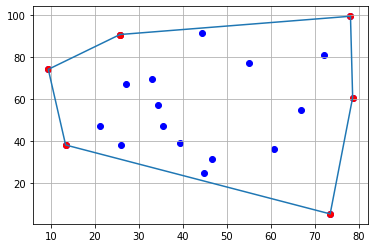

In [186]:
# test randomly generated set of points of size n
# try it out!

random_thing = generate_random_point_set(20)
random_test_case={
    'one':{'input':random_thing, 'nominal_output':random_thing[:]}
}
test_convex_hull_small(random_test_case)

next n 1000
points generated 1000
algorithm ran 1000
result len 13
next n 10000
points generated 10000
algorithm ran 10000
result len 27
next n 100000
points generated 100000
algorithm ran 100000
result len 29
next n 1000000
points generated 1000000
algorithm ran 1000000
result len 33
next n 10000000
points generated 10000000
algorithm ran 10000000
result len 42
next n 100000000
points generated 100000000
algorithm ran 100000000
result len 50
SCALING FACTOR: mean(actual results)/mean(theoretical_results)
606.7355051231766


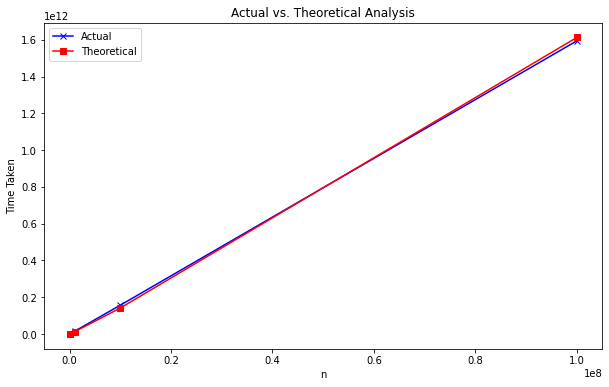

   Iterations (n)  Actual Time (ns)  Theoretical Units  Adjusted Theoretical Time  Scaling Factor
0            1000          36353000           9965.784                6046595.162         606.736
1           10000         147265000         132877.124               80621268.825         606.736
2          100000        1218244000        1660964.047             1007765860.317         606.736
3         1000000       14862478000       19931568.569            12093190323.806         606.736
4        10000000      156489916000      232534966.642           141087220444.405         606.736
5       100000000     1593945965000     2657542475.910          1612425376507.484         606.736
\begin{tabular}{lrrrrr}
\toprule
{} &  Iterations (n) &  Actual Time (ns) &  Theoretical Units &  Adjusted Theoretical Time &  Scaling Factor \\
\midrule
0 &            1000 &          36353000 &           9965.784 &                6046595.162 &         606.736 \\
1 &           10000 &         147265000 &        

In [176]:
def algorithm_runner(iterations):
    results=[]
    for n in iterations:
        print('next n', n)
        run_sum=0
        points = generate_random_point_set(n)
        print('points generated', n)
        start_time = time.time_ns()
        res = convex_hull(sorted(points))
        run_sum+=time.time_ns() - start_time
        print('algorithm ran', n )
        print('result len', len(res))
        results.append(run_sum)
    return results


 
iterations = [10**3, 10**4, 10**5, 10**6, 10**7, 10**8]
result = algorithm_runner(iterations)
printable_results = create_results_package(iterations, result)
plot_time(printable_results)
tabularize_results(printable_results)    


